In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/signal-fast-radio-burst-detection/sample_submission.csv
/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/B1933+16_59475_68410_reduced_fc_0001023_labels.csv
/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/B0531+21_58713_43190_reduced_fc_0001023_labels.csv
/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/J1022+1001_59503_29150_reduced_fc_0004611_labels.csv
/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/J0621+1002_59691_60070_reduced_fc_0003041_labels.csv
/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/B0531+21_2020-05-31-11_36_46_0020479_labels.csv
/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/B0531+21_58713_43190_reduced_fc_0004095_labels.csv
/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train/B0531+21_58713_43190_reduced_fc_0029695_labels.csv
/kaggle/input/signal-fast-radio-b

In [ ]:
import numpy as np

file_path = "/kaggle/input/signal-fast-radio-burst-detection/test/test/13.npy"
data = np.load(file_path, allow_pickle=True)

print("Shape:", data.shape)
print("Data Type:", type(data))
print("First 5 rows:\n", data)


Shape: (262144, 256)
Data Type: <class 'numpy.ndarray'>
First 5 rows:
 [[165. 165. 169. ... 140. 131. 152.]
 [173. 141. 146. ... 157. 165. 143.]
 [141. 150. 138. ... 151. 173. 145.]
 ...
 [166. 168. 129. ... 140. 143. 149.]
 [163. 149. 171. ... 142. 161. 168.]
 [175. 148. 150. ... 126. 142. 164.]]


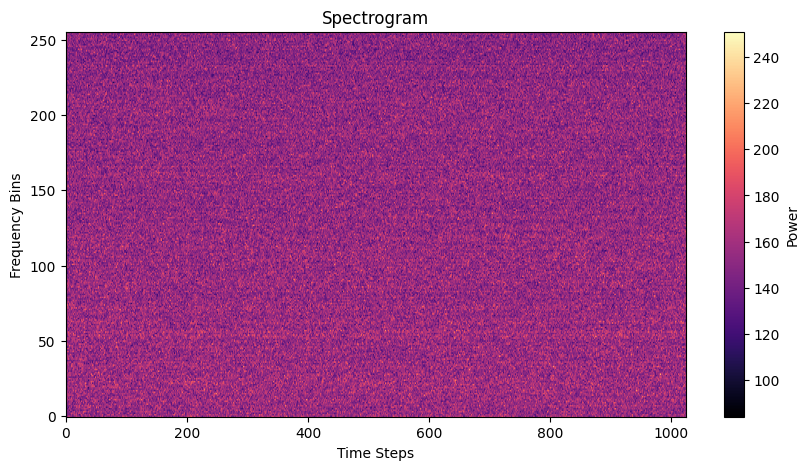

In [ ]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10, 5))
plt.imshow(data[:1024].T, aspect='auto', origin='lower', cmap='magma')
plt.colorbar(label="Power")
plt.xlabel("Time Steps")
plt.ylabel("Frequency Bins")
plt.title("Spectrogram")
plt.show()


In [ ]:
import glob
def process_signal(signal, num_features=256):
    signal = signal / np.max(np.abs(signal))  
    signal = signal[:num_features] 
    return signal

def load_labels(label_file):
    label_df = pd.read_csv(label_file)
    return label_df['labels'].values

def load_train_dataset_limited(npy_dir, label_dir):
    npy_files = sorted(glob.glob(os.path.join(npy_dir, '*.npy')))
    label_files = sorted(glob.glob(os.path.join(label_dir, '*_labels.csv')))
    
    total_bytes = 0
    all_signals = []
    all_labels = []
    
    for npy_file, label_file in zip(npy_files, label_files):
        file_size = os.path.getsize(npy_file)
        total_bytes += file_size
        signal_full = np.load(npy_file)
        num_blocks = len(signal_full) // 256
        signals = np.array([process_signal(signal_full[i*256:(i+1)*256]) for i in range(num_blocks)])
        
        labels = load_labels(label_file)
        
        if signals.shape[0] != len(labels):
            print(f"Warning: In {os.path.basename(npy_file)}, event count {signals.shape[0]} != label count {len(labels)}")
            min_len = min(signals.shape[0], len(labels))
            signals = signals[:min_len]
            labels = labels[:min_len]
        
        all_signals.append(signals)
        all_labels.append(labels)
    
    X = np.concatenate(all_signals, axis=0)
    y = np.concatenate(all_labels, axis=0)
    print(f"Loaded total data size: {total_bytes/(1024**3):.2f} GB")
    return X, y

In [5]:
npy_dir = '/kaggle/input/signal-fast-radio-burst-detection/train/train'
label_dir = '/kaggle/input/signal-fast-radio-burst-detection/train-labels-corrected/train'
X, y = load_train_dataset_limited(npy_dir, label_dir)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

หยุดโหลด: การโหลด /kaggle/input/signal-fast-radio-burst-detection/train/train/B0531+21_2020-05-31-11_36_46_0012287.npy จะทำให้เกิน 3221225472 bytes
Loaded total data size: 2.75 GB
X shape: (11264, 256, 256)
y shape: (11264,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (9011, 256, 256)
X_val shape: (2253, 256, 256)
y_train shape: (9011,)
y_val shape: (2253,)


In [ ]:
import numpy as np
import pandas as pd

label_map = {
    'Narrow': 1,
    'Pulse': 2,
    'Broad': 3,
    'Narrow+Pulse': 4
}

def map_labels(label):
    if pd.isna(label): 
        return 0
    return label_map.get(label, 0)  

y_train_numeric = np.array([map_labels(label) for label in y_train])
y_val_numeric = np.array([map_labels(label) for label in y_val])

print("y_train_numeric:", y_train_numeric)
print("y_val_numeric:", y_val_numeric)


y_train_numeric: [0 0 0 ... 0 3 0]
y_val_numeric: [0 1 0 ... 0 0 0]


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid') 
])

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      31,490,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,509,121 (120.20 MB)

 Trainable params: 31,509,121 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

history = model.fit(X_train, y_train_numeric, epochs=10, batch_size=32, validation_data=(X_val, y_val_numeric))

print("Training completed")

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 55ms/step - accuracy: 0.9239 - loss: 0.3541 - val_accuracy: 0.9902 - val_loss: 0.1270
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9707 - loss: -0.1728 - val_accuracy: 0.9902 - val_loss: 0.2496
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9747 - loss: -1.6779 - val_accuracy: 0.9902 - val_loss: 0.5413
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9733 - loss: -18.0789 - val_accuracy: 0.9902 - val_loss: 2.6557
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9760 - loss: -68.4252 - val_accuracy: 0.9902 - val_loss: 6.6333
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9740 - loss: -165.3730 - val_accuracy: 0.9902 - val_loss: 15.5991
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9776 - loss: -207.0717 - val_accuracy: 0.9902 - val_loss: 30.7073
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9679 - loss: -1

In [12]:
val_loss, val_acc = model.evaluate(X_val, y_val_numeric)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_acc}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9872 - loss: 143.0954
Validation Loss: 171.08775329589844
Validation Accuracy: 0.9902352690696716


In [ ]:
import glob
import os
import numpy as np
import pandas as pd

def process_signal(signal, num_features=256):
    signal = signal / np.max(np.abs(signal))  
    signal = signal[:num_features] 
    return signal

def load_test_dataset(test_dir):
    npy_files = sorted(glob.glob(os.path.join(test_dir, '*.npy')))
    
    total_bytes = 0
    all_signals = []
    
    for test_dir in npy_files:
        file_size = os.path.getsize(test_dir)
        total_bytes += file_size
        
        signal_full = np.load(test_dir)
        num_blocks = len(signal_full) // 256
        signals = np.array([process_signal(signal_full[i*256:(i+1)*256]) for i in range(num_blocks)])
        
        all_signals.append(signals)
    
    X_test = np.concatenate(all_signals, axis=0)
    print(f"Loaded total data size: {total_bytes/(1024**3):.2f} GB")
    return X_test


In [15]:
test_dir = '/kaggle/input/signal-fast-radio-burst-detection/test/test'
X_test = load_test_dataset(test_dir)
print(f"X shape: {X_test.shape}")


Loaded total data size: 6.86 GB
X shape: (28108, 256, 256)


In [16]:
X_test.shape

(28108, 256, 256)

In [17]:
y_pred = model.predict(X_test)

879/879 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step


In [19]:
y_pred.shape

(28108, 1)

In [ ]:
import pandas as pd
import numpy as np

y_pred_binary = np.random.random((28108, 3)) 

y_pred_binary = (y_pred_binary > 0.5).astype(int)
sample_submission = pd.read_csv('/kaggle/input/signal-fast-radio-burst-detection/sample_submission.csv')

if len(sample_submission) == len(y_pred_binary):
    sample_submission['pulse'] = y_pred_binary[:, 0]
    sample_submission['broad'] = y_pred_binary[:, 1]
    sample_submission['narrow'] = y_pred_binary[:, 2]
    sample_submission.to_csv('submission.csv', index=False)